# Hands-on 3D PET reconstruction using Plug-and-play methods

In this lab, we will investigate how to use a pre-trained neural network into the iterations of an optimization algorithm and we will assess its benefits and limits compared to classical iterative reconstruction. Our goal is to reconstruct a PET image from low-dose data with the quality of a high-dose reconstruction.

## Setup

Run cells to create lab environnement.

In [1]:
!git clone https://github.com/marsvn/TP_janv25.git

Cloning into 'TP_janv25'...
remote: Enumerating objects: 141, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 141 (delta 61), reused 19 (delta 7), pack-reused 37 (from 1)
Receiving objects: 100% (141/141), 83.32 MiB | 16.92 MiB/s, done.
Resolving deltas: 100% (67/67), done.
Updating files: 100% (25/25), done.


In [2]:
!unzip TP_janv25/lib/interfile.zip -d /content
!pip install /content/interfile
!pip install bm4d
!pip install ninja
!pip install torchmetrics
!apt-get update
!apt-get install -y libgsl-dev
!pip install --upgrade cython

Archive:  TP_janv25/lib/interfile.zip
   creating: /content/interfile/
  inflating: /content/interfile/MANIFEST.in  
   creating: /content/interfile/build/
   creating: /content/interfile/build/bdist.linux-x86_64/
   creating: /content/interfile/build/lib/
   creating: /content/interfile/build/lib/interfile/
   creating: /content/interfile/build/lib/interfile/examples/
  inflating: /content/interfile/build/lib/interfile/examples/pet_sinogram.s.hdr  
  inflating: /content/interfile/build/lib/interfile/examples/parsed_listmode.pickle  
  inflating: /content/interfile/build/lib/interfile/examples/__init__.py  
  inflating: /content/interfile/build/lib/interfile/examples/pet_listmode.l.hdr  
  inflating: /content/interfile/build/lib/interfile/examples/parsed_sinogram.pickle  
  inflating: /content/interfile/build/lib/interfile/Interfile.py  
   creating: /content/interfile/build/lib/interfile/tests/
  inflating: /content/interfile/build/lib/interfile/tests/__init__.py  
  inflating: /conte

In [3]:
!unzip TP_janv25/lib/pyPETLibs.zip -d /content
!pip install /content/pyPETLibs

Archive:  TP_janv25/lib/pyPETLibs.zip
   creating: /content/pyPETLibs/
  inflating: /content/pyPETLibs/README.md  
   creating: /content/pyPETLibs/tests/
   creating: /content/pyPETLibs/tests/tests_env/
  inflating: /content/pyPETLibs/tests/tests_env/launch_ncu_after.cmd  
  inflating: /content/pyPETLibs/tests/tests_env/launch_sudo_backproj.cmd  
  inflating: /content/pyPETLibs/tests/tests_env/launch_ncu.cmd  
  inflating: /content/pyPETLibs/tests/tests_env/test_notworking.txt  
  inflating: /content/pyPETLibs/tests/tests_env/test.txt  
  inflating: /content/pyPETLibs/tests/tests_env/launch_ncu_notworking.cmd  
  inflating: /content/pyPETLibs/tests/tests_env/test_after.txt  
  inflating: /content/pyPETLibs/tests/tests_env/launch_ncu_working.cmd  
  inflating: /content/pyPETLibs/tests/tests_env/test_working.txt  
  inflating: /content/pyPETLibs/tests/tests_env/test_backproj.txt  
  inflating: /content/pyPETLibs/tests/tests_env/test_default.txt  
  inflating: /content/pyPETLibs/tests/tes

In [4]:
!unzip TP_janv25/lib/pyTorchPET.zip -d /content
!pip install /content/pyTorchPET

Archive:  TP_janv25/lib/pyTorchPET.zip
   creating: /content/pyTorchPET/
  inflating: /content/pyTorchPET/README.md  
   creating: /content/pyTorchPET/dist/
  inflating: /content/pyTorchPET/dist/torchPETADMM-1.0.0.dev0-py3.10.egg  
   creating: /content/pyTorchPET/torchPETADMM/
   creating: /content/pyTorchPET/torchPETADMM/reconstruction/
  inflating: /content/pyTorchPET/torchPETADMM/reconstruction/BB.py  
   creating: /content/pyTorchPET/torchPETADMM/reconstruction/__pycache__/
  inflating: /content/pyTorchPET/torchPETADMM/reconstruction/__pycache__/__init__.cpython-310.pyc  
  inflating: /content/pyTorchPET/torchPETADMM/reconstruction/__pycache__/ADMM.cpython-310.pyc  
  inflating: /content/pyTorchPET/torchPETADMM/reconstruction/__pycache__/EM.cpython-310.pyc  
  inflating: /content/pyTorchPET/torchPETADMM/reconstruction/EM.py  
  inflating: /content/pyTorchPET/torchPETADMM/reconstruction/prox_usual.py  
  inflating: /content/pyTorchPET/torchPETADMM/reconstruction/ADMM.py  
  inflati

In [5]:
import torch
import os
from interfile import Interfile as Interfile
from PETLibs import *
import PETLibs
import numpy as np
from argparse import ArgumentParser
from torch.nn import functional as F
from matplotlib import pyplot as plt
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
from TP_janv25.proj_utils import preprocess_data, postprocess_data, GPU_log_likelihood, GPUBiographProxRecons, GPUBiographEMRecons
from TP_janv25.IR_utils import prox_TV_L1
import math
import numbers
import bm4d

os.environ["CASTOR_CONFIG"] = "/content/TP_janv25/"
DEVICE = "cuda:0"

/usr/local/lib/python3.10/dist-packages/PETLibs/recons/GPURecons.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange,tqdm


## Load data

We consider similated data for Siemens Biograph TruePoint TrueV system. Set the scanner configuration and reconstruction grid options.

In [10]:
XYZ=True
dim_vol = [128,128,109] #number of voxels in final numpy image (in XYZ convention if XYZ is true)
vox_size=[2.03642,2.03642,2.027]
data_TP_folder = "TP_janv25/"
ParamsGPUEM=PETLibs.recons.GPUBiographReconsParams(lut_name=data_TP_folder+"PET_SIEMENS_BIOGRAPH6_TRUEPOINT_TRUEV.lut",
                                    vox_size=vox_size,im_dim=dim_vol,nit=8, verbose=False,nsubsets=14,VRing=True,XYZ=XYZ, deviceGPU=DEVICE)

Load simulated low dose data

In [11]:
castor_df_hdr="realizationj00414-1.cdh"
castor_df_dir=data_TP_folder+"data_TP/j00414/realizationj00414-1"
dose_reduc = 5.0

castor_df_hdr_fpath=os.path.join(castor_df_dir,castor_df_hdr)
dict_sino=PETLibs.recons.GPURecons.GPUCASToRSinos(castor_df_hdr_fpath, castor_df_dir, reconsParams=ParamsGPUEM)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
!cp /content/drive/MyDrive/realizationj00414-1.cdf /content/TP_janv25/data_TP/j00414/realizationj00414-1/



`dict_sino` is a dictionary containing sinograms and corrections factors (random, scatter, attenuation, normalization). Its keys are dict_keys(['mult', 'add', 'mask', 'val'])



>Get number of events in sinogram.

Load corresponding simulated high dose OSEM reconstruction

In [16]:
ordose_hdr=Interfile.load(data_TP_folder+"data_TP/j00414/originaldose-red-j00414-1-8it-14sub.hdr")
ordose_hdr['name of data file']['value']="originaldose-red-j00414-1-8it-14sub.ima"
ordose,_,_,_,_=PETLibs.ios.getNPArrayFromCASToRInterfileHeader(ordose_hdr,data_TP_folder+"data_TP/j00414",verbose=False)


xtrue = ordose

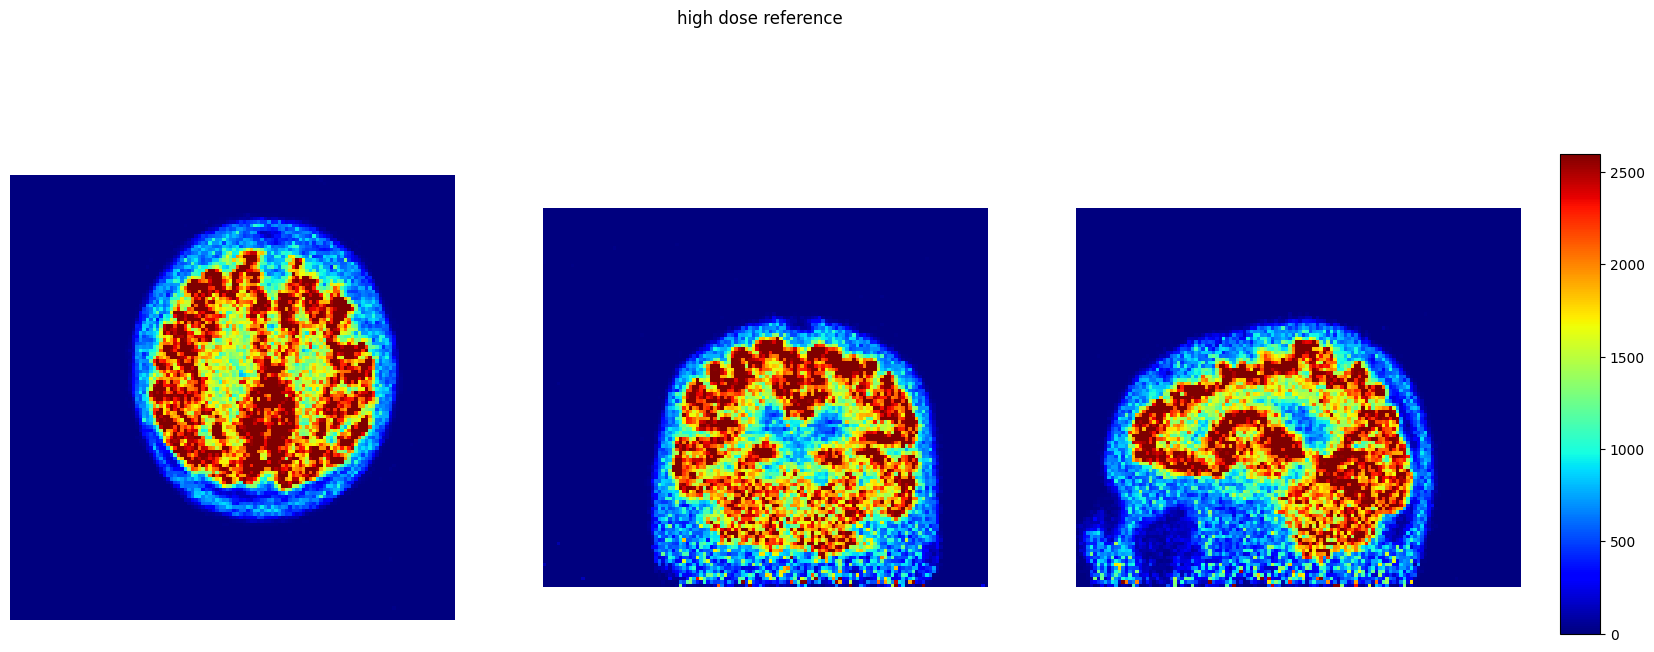

In [17]:
fig=PETLibs.utils.display3D_1cbar(ordose,interpolation='none', vmin = 0, vmax= 2600, title="high dose reference")

## Part I: ADMM reconstruction


A common way of reconstructing a 3D image $\overline{x}$ from the set of sinograms $y$ is to estimate $\overline{x}$ by the minimizer $\hat{x}$ of

$$
 L(x) + \lambda g(D x) \qquad  (P)
$$

Usually, $g$ is chosen as an $\ell_1$ norm and $D$ typically refer to a wavelet transform or the gradient operator. In the latter, the regularization is called **total variation**.


For Problem (P), the alternating direction method of multipliers (ADMM) writes as

$x^{(k+1)} = \rm{prox}_{L/\rho}(z^{(k)}+u^{(k)})$ (S1)

$z^{(k+1)} = \rm{prox}_{\lambda g(D \cdot)/\rho}(x^{(k+1)}  -u^{(k)})$ (S2)

$u^{(k+1)}=u^{(k)} + x^{(k+1)} -  z^{(k+1)}$ (S3)

where $\rho>0$.

The sequences of iterates $(x_k)_k$ and $(z_k)_k$ converge to $\hat{x}$.

Below is the template of an implementation of ADMM for solving (P):
- Function `GPUBiographProxRecons` computes (S1)
- Function `prox_TV_L1` computes (S2) when g is the total variation

>*Keep the `preprocess_data` and `postprocess_data` before and after the computation of `prox_TV_L1` as these two functions do not assume the same ordering of the data (XYZ vs ZYX).*

In [18]:
def admm(x0, nit_admm, lbd, rho, BiographParams, dict_sino):

    v=torch.tensor(np.zeros_like(x0), dtype=torch.float32,device=DEVICE)
    u=torch.zeros_like(v, device=DEVICE)

    for _ in range(nit_admm):


        x=GPUBiographProxRecons(BiographReconsParams=BiographParams,xprox=v-u,pnlt_beta=rho,dict_sino=dict_sino, tensor_output = True).squeeze()
        n_image=preprocess_data(x+u, tensorFlag=True)
        v = prox_TV_L1(n_image, lamb=lbd/rho, maxit=1000, verbose=0)
        v=postprocess_data(v, tensorFlag=True)

        u = u + x - v


    return x

>I.1 Study the impact of $\lambda$ and $\rho$ on image quality. Is $\rho$ allowed to take any values? What is the optimal value of $\lambda$?

Iterations ProxRecons: 100%|██████████| 112/112 [00:06<00:00, 17.52Iteration(s)/s]


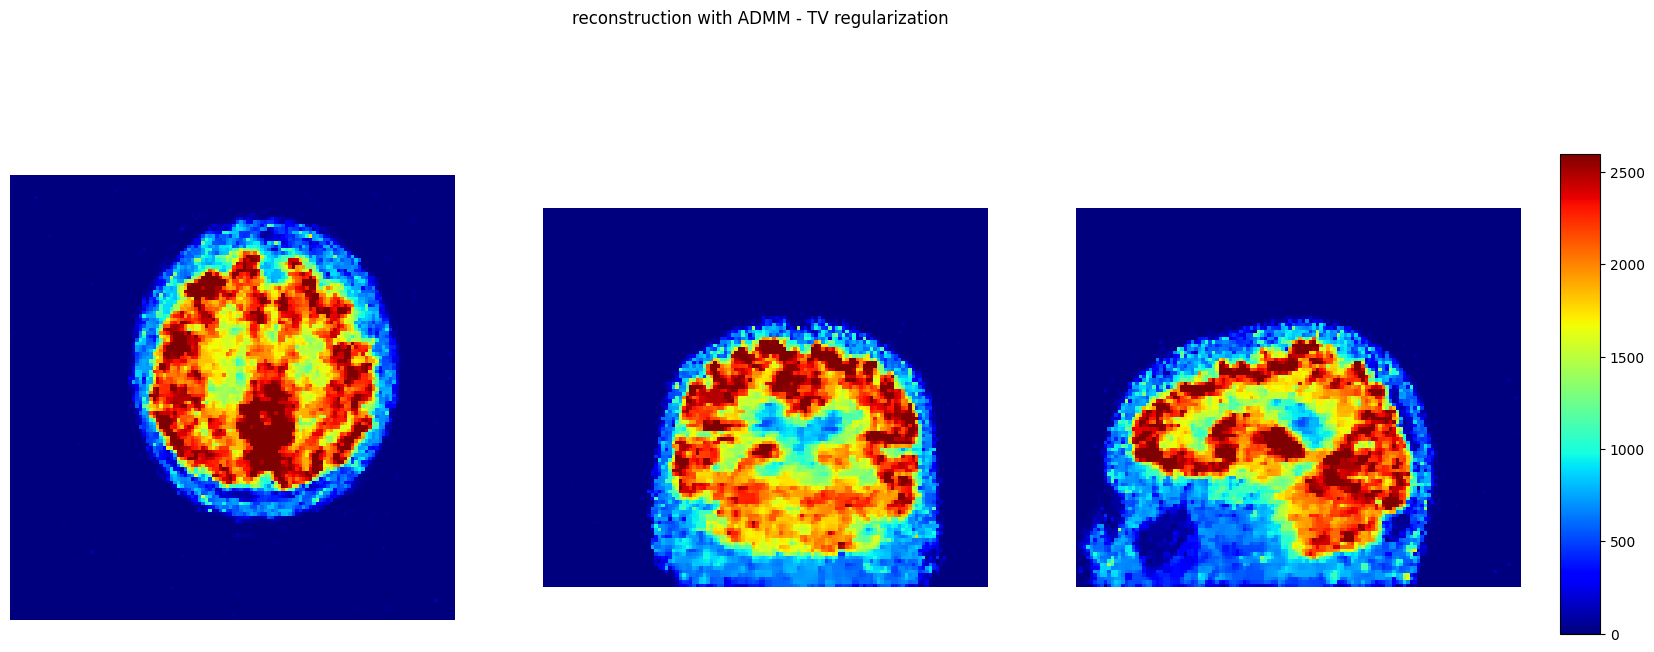

In [20]:
nit_admm = 10
rho = 1e-6
lbd = 0.00002

x_admm = admm(x0=ordose, nit_admm=nit_admm, lbd=lbd, rho=rho, BiographParams=ParamsGPUEM, dict_sino=dict_sino)
x_admm = x_admm.squeeze().cpu().detach().numpy()

fig=PETLibs.utils.display3D_1cbar(x_admm,interpolation='none', vmin = 0, vmax= 2600, title='reconstruction with ADMM - TV regularization')

## Part II: Proximity operator vs denoiser

> Reconstruct the low-dose data using the EM algorithm with 14 subsets and 10 iterations.

In [ ]:
# remove
ParamsGPUEM=PETLibs.recons.GPUBiographReconsParams(lut_name=data_TP_folder+"PET_SIEMENS_BIOGRAPH6_TRUEPOINT_TRUEV.lut",
                                    vox_size=vox_size,im_dim=dim_vol,nit=10, verbose=False,nsubsets=14,VRing=True,XYZ=XYZ,deviceGPU=DEVICE)


recon_EM_LD = GPUBiographEMRecons(castor_df_hdr_fpath, castor_df_dir,reconsParams=ParamsGPUEM, dict_sino=dict_sino, verbose=False)

In [21]:
ParamsGPUEM=PETLibs.recons.GPUBiographReconsParams(lut_name=data_TP_folder+"PET_SIEMENS_BIOGRAPH6_TRUEPOINT_TRUEV.lut",
                                    vox_size=vox_size,im_dim=dim_vol,nit=X, verbose=False,nsubsets=X,VRing=True,XYZ=XYZ,deviceGPU=DEVICE)


recon_EM_LD = GPUBiographEMRecons(castor_df_hdr_fpath, castor_df_dir,reconsParams=ParamsGPUEM, dict_sino=dict_sino, verbose=False)

NameError: name 'X' is not defined

Display the high-dose reference and low-dose OSEM reconstruction.

In [ ]:
fig=PETLibs.utils.display3D_1cbar(ordose,interpolation='none', vmin = 0, vmax= 2600, title="high dose reference")
fig=PETLibs.utils.display3D_1cbar(recon_EM_LD,interpolation='none', vmin = 0, vmax= 2600, title="OSEM low dose")

>II.1 Apply different post-reconstruction denoisers (TV regularization, bm4d, gaussian filter and the deep models: net0, net1 and net2) on the low dose image. Compare their effects, execution time and complexity.


In [ ]:
xnoisy = recon_EM_LD

### Post reconstruction denoiser: TV prox

In [ ]:
reg_par = 250
x_noisy = preprocess_data(xnoisy)
xtv = prox_TV_L1(x_noisy, lamb=reg_par, maxit=1000)
xtv = postprocess_data(xtv)

### Post reconstruction denoiser: gaussian filtering

In [ ]:
class GaussianSmoothing(torch.nn.Module):
    """
    Apply gaussian smoothing on a
    1d, 2d or 3d tensor. Filtering is performed seperately for each channel
    in the input using a depthwise convolution.
    Arguments:
        channels (int, sequence): Number of channels of the input tensors. Output will
            have this number of channels as well.
        kernel_size (int, sequence): Size of the gaussian kernel.
        sigma (float, sequence): Standard deviation of the gaussian kernel.
        dim (int, optional): The number of dimensions of the data.
            Default value is 2 (spatial).
    """
    def __init__(self, channels, kernel_size, sigma, dim=2):
        super(GaussianSmoothing, self).__init__()
        if isinstance(kernel_size, numbers.Number):
            kernel_size = [kernel_size] * dim
        if isinstance(sigma, numbers.Number):
            sigma = [sigma] * dim
            #you should smooth with a Gaussian filter approximately three times the size of your voxel.

        # The gaussian kernel is the product of the
        # gaussian function of each dimension.
        kernel = 1
        meshgrids = torch.meshgrid(
            [
                torch.arange(size, dtype=torch.float32)
                for size in kernel_size
            ]
        )
        for size, std, mgrid in zip(kernel_size, sigma, meshgrids):
            mean = (size - 1) / 2
            kernel *= 1 / (std * math.sqrt(2 * math.pi)) * \
                      torch.exp(-((mgrid - mean) / std) ** 2 / 2)

        # Make sure sum of values in gaussian kernel equals 1.
        kernel = kernel / torch.sum(kernel)

        # Reshape to depthwise convolutional weight
        kernel = kernel.view(1, 1, *kernel.size())
        kernel = kernel.repeat(channels, *[1] * (kernel.dim() - 1))

        self.register_buffer('weight', kernel)
        self.groups = channels

        if dim == 1:
            self.conv = F.conv1d
        elif dim == 2:
            self.conv = F.conv2d
        elif dim == 3:
            self.conv = F.conv3d
        else:
            raise RuntimeError(
                'Only 1, 2 and 3 dimensions are supported. Received {}.'.format(dim)
            )

    def forward(self, input):
        """
        Apply gaussian filter to input.
        Arguments:
            input (torch.Tensor): Input to apply gaussian filter on.
        Returns:
            filtered (torch.Tensor): Filtered output.
        """
        return self.conv(input, weight=self.weight, groups=self.groups, padding=2)



def sigma2fwhm(sigma):
     return sigma * np.sqrt(8 * np.log(2))


def fwhm2sigma(fwhm):
    return fwhm / np.sqrt(8 * np.log(2))

In [ ]:
kernel_size = 5
fwhm = 1.5
sigma_gaussian = fwhm2sigma(fwhm)
x_noisy = preprocess_data(xnoisy)
smoothing = GaussianSmoothing(1, kernel_size, sigma_gaussian, 3).cuda()
xgauss = postprocess_data(smoothing(x_noisy))

### Post reconstruction denoiser: BM3D

In [ ]:
reg_par = 700
xbm3d_2=bm4d.bm4d(xnoisy.squeeze(), reg_par)

### Post reconstruction deep denoisers

In [ ]:
from TP_janv25.DL_utils import MyDenoiser, MyLDenoiser

Loading deep networks

>II.2 Describe the architecture of the three neural networks net0, net1 and net2.

In [ ]:
net0 = MyLDenoiser()
net1 = MyDenoiser()
net2 = MyDenoiser()


if torch.cuda.is_available():
    net0 = net0.cuda()
    net1 = net1.cuda()
    net2 = net2.cuda()


filename = data_TP_folder+'net0.ckpt'
checkpoint = torch.load(filename)
net0.load_state_dict(checkpoint['state_dict'], strict=True)
net0.eval()


filename = data_TP_folder+'net2.ckpt'
checkpoint = torch.load(filename)
net2.load_state_dict(checkpoint['state_dict'], strict=True)
net2.eval()

filename = data_TP_folder+'net1.ckpt'
checkpoint = torch.load(filename)
net1.load_state_dict(checkpoint['state_dict'], strict=True)
net1.eval()

Comparing all denoisers and display denoised images  

In [ ]:
x_noisy = preprocess_data(xnoisy)
xnet0 = postprocess_data(net0(x_noisy))

In [ ]:
# remove
x_noisy = preprocess_data(xnoisy)
xnet0 = postprocess_data(net0(x_noisy))
xnet2 = postprocess_data(net2(x_noisy))
xnet1 = postprocess_data(net1(x_noisy))

In [ ]:
# remove

fig=PETLibs.utils.display3D_1cbar(xtrue,interpolation='none', vmin = 0, vmax= 2600, title='Reference')
fig=PETLibs.utils.display3D_1cbar(xnoisy,interpolation='none', vmin = 0, vmax= 2600, title='EM')
fig=PETLibs.utils.display3D_1cbar(xtv,interpolation='none', vmin = 0, vmax= 2600, title='Denoised with total variation')
fig=PETLibs.utils.display3D_1cbar(xgauss,interpolation='none', vmin = 0, vmax= 2600, title='Denoised with Gaussian')
fig=PETLibs.utils.display3D_1cbar(xbm3d_2,interpolation='none', vmin = 0, vmax= 2600, title='Denoised with BM3D')
fig=PETLibs.utils.display3D_1cbar(xnet0,interpolation='none', vmin = 0, vmax= 2600, title='Denoised with net0')
fig=PETLibs.utils.display3D_1cbar(xnet1,interpolation='none', vmin = 0, vmax= 2600, title='Denoised with net1')
fig=PETLibs.utils.display3D_1cbar(xnet2,interpolation='none', vmin = 0, vmax= 2600, title='Denoised with net2')

> Compare quantitatively the denoising methods

In [ ]:
import torchmetrics
compute_MSE = torch.nn.MSELoss()
compute_MAE = torchmetrics.MeanAbsoluteError()
compute_SS = torchmetrics.StructuralSimilarityIndexMeasure()

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(


In [ ]:
# REMOVE comparing the MSE associated with each method
criterion = torch.nn.MSELoss()
mse_em = criterion(torch.tensor(xnoisy), torch.tensor(xtrue)).item()
mse_tv = criterion(torch.tensor(xtv), torch.tensor(xtrue)).item()
mse_bm3d = criterion(torch.tensor(xbm3d_2), torch.tensor(xtrue)).item()
mse_gauss = criterion(torch.tensor(xgauss), torch.tensor(xtrue)).item()
mse_net0 = criterion(torch.tensor(xnet0), torch.tensor(xtrue)).item()
mse_net2 = criterion(torch.tensor(xnet2), torch.tensor(xtrue)).item()
mse_net1 = criterion(torch.tensor(xnet1), torch.tensor(xtrue)).item()



print('MSE EM: ', mse_em)
print('MSE TV: ', mse_tv)
print('MSE BM3D: ', mse_bm3d)
print('MSE Gauss: ', mse_gauss)
print('MSE net0: ', mse_net0)
print('MSE net1: ', mse_net1)
print('MSE net2: ', mse_net2)


MSE EM:  163940.1875
MSE TV:  71939.93888083509
MSE BM3D:  50072.31095467056
MSE Gauss:  38613.93912002527
MSE net0:  31877.003859656816
MSE net1:  28386.496318602756
MSE net2:  28078.334607167806


> Compare execution time of all denoisers

In [ ]:
import timeit

## Part III: PnP ADMM with prox surrogate

> III.1 Replace the proximity operator of TV by net1 and net2. Does PnP ADMM still converge? To answer this question, monitor convergence metrics (primal and dual residuals) in the ADMM algorithm.

In [ ]:
def pnp_admm(x0, nit_admm, model, rho, max_iter_jacobian, BiographParams, dict_sino, target, nb_everyIter_jac = 1):

    v=torch.tensor(np.zeros_like(x0), dtype=torch.float32,device="cuda")
    u=torch.zeros_like(v)

    model_run=lambda v: model(v)[0]


    for i in range(nit_admm):


        x=GPUBiographProxRecons(BiographReconsParams=BiographParams,xprox=v-u,pnlt_beta=rho,dict_sino=dict_sino, tensor_output = True).squeeze()

        #### ITERATION TO FILL


    ### STORE METRICS HERE
    results={}
    results["x"]=x
    return results

In [ ]:
# REMOVE

def pnp_admm(x0, nit_admm, model, rho, max_iter_jacobian, BiographParams, dict_sino, target, nb_everyIter_jac = 1):

    v=torch.tensor(np.zeros_like(x0), dtype=torch.float32,device=DEVICE)
    u=torch.zeros_like(v)

    criterion = torch.nn.MSELoss()

    mse = []
    log_l = []
    norm1 = []
    norm2 = []
    reg = []
    model_run=lambda v: model(v)[0]


    for i in range(nit_admm):


        x=GPUBiographProxRecons(BiographReconsParams=BiographParams,xprox=v-u,pnlt_beta=rho,dict_sino=dict_sino, tensor_output = True).squeeze()

        loss = criterion(preprocess_data(x, tensorFlag=True), target)
        mse.append(loss.item())
        l = GPU_log_likelihood(x, eps =0,BiographParams=BiographParams,dict_sino=dict_sino)
        log_l.append(l)

        v_old = v
        n_image=preprocess_data(x+u, tensorFlag=True)
        v = model_run(n_image)
        v=postprocess_data(v.squeeze(), tensorFlag=True)

        out_detached = n_image.detach()
        out_detached.requires_grad_()
        out_net_reg = 2.*model_run(out_detached)-out_detached
        if i%nb_everyIter_jac==0:
            reg_loss,_ = compute_norm_jac(out_detached, out_net_reg, tol = 1e-3, max_iter = max_iter_jacobian)
            reg_loss = reg_loss.item()
            print("jac=", reg_loss)
            reg.append(reg_loss)


        primalN=torch.linalg.norm(x-v)
        dualN=torch.linalg.norm(v-v_old)

        if i > 0:
            if (dualN/torch.linalg.norm(v)<prec) & (primalN/torch.linalg.norm(v)<prec):
                print("Convergence reached")
                break

            norm1.append(primalN.item())
            norm2.append(dualN.item())

        u = u + x - v

    results={}
    results["x"]=x
    results["mse"]=mse
    results["reg"]=reg
    results["logl"]=log_l
    results["norm1"]=norm1
    results["norm2"]=norm2

    return results

In [ ]:
max_iter_jacobian = 3
device = 'cuda'
prec = 1e-3
nit_admm = 40
pnlt_beta = 1e-7
nb_everyIter_jac = 10
test_model =

results_admm = pnp_admm(x0=xnoisy, nit_admm=nit_admm, model=test_model, rho=pnlt_beta, max_iter_jacobian=max_iter_jacobian, BiographParams=ParamsGPUEM, dict_sino=dict_sino, target=preprocess_data(ordose), nb_everyIter_jac=nb_everyIter_jac)
x_admm = results_admm["x"].squeeze().cpu().detach().numpy()

fig=PETLibs.utils.display3D_1cbar(x_admm,interpolation='none', vmin=0, vmax=2600, title='reconstruction with PnP ADMM - net3')

### PLOT METRICS HERE


In [ ]:
# Remove
results_admm = pnp_admm(x0=xnoisy, nit_admm=nit_admm, model=net1, rho=pnlt_beta, max_iter_jacobian=max_iter_jacobian, BiographParams=ParamsGPUEM, dict_sino=dict_sino, target=preprocess_data(ordose), nb_everyIter_jac=nb_everyIter_jac)
x_admm = results_admm["x"].squeeze().cpu().detach().numpy()
mse_admm = results_admm["mse"]
reg_admm = results_admm["reg"]
logl_admm = results_admm["logl"]
norm1_admm = results_admm["norm1"]
norm2_admm = results_admm["norm2"]


fig=PETLibs.utils.display3D_1cbar(x_admm,interpolation='none', vmin=0, vmax=2600, title='reconstruction with PnP ADMM - net3')

#plotting mse as a function of iteration
plt.figure()
plt.plot(mse_admm)
plt.title('MSE')
plt.show()

#plotting log likelihood as a function of iteration
plt.figure()
plt.plot(logl_admm)
plt.title('Log likelihood')
plt.show()

#plotting norm1 as a function of iteration
plt.figure()
plt.plot(norm1_admm)
plt.title('Norm1')
plt.show()

#plotting norm2 as a function of iteration
plt.figure()
plt.plot(norm2_admm)
plt.title('Norm2')
plt.show()

#plotting reg as a function of iteration
plt.figure()
plt.plot(reg_admm)
plt.title('Reg')
plt.show()

In [ ]:
# Remove
results_admm2 = pnp_admm(x0=xnoisy, nit_admm=nit_admm, model=net2, rho=pnlt_beta, max_iter_jacobian=max_iter_jacobian, prec=prec, device=device, BiographParams=ParamsGPUEM, dict_sino=dict_sino, target=preprocess_data(ordose),nb_everyIter_jac=nb_everyIter_jac)

x_admm2 = results_admm2["x"].squeeze().cpu().detach().numpy()
mse_admm2 = results_admm2["mse"]
reg_admm2 = results_admm2["reg"]
logl_admm2 = results_admm2["logl"]
norm1_admm2 = results_admm2["norm1"]
norm2_admm2 = results_admm2["norm2"]


fig=PETLibs.utils.display3D_1cbar(x_admm2,interpolation='none', vmin=0, vmax=2600, title='reconstruction with PnP ADMM - net2')

#plotting mse as a function of iteration
plt.figure()
plt.plot(mse_admm2)
plt.title('MSE')
plt.show()

#plotting log likelihood as a function of iteration
plt.figure()
plt.plot(logl_admm2)
plt.title('Log likelihood')
plt.show()

#plotting norm1 as a function of iteration
plt.figure()
plt.plot(norm1_admm2)
plt.title('Norm1')
plt.show()

#plotting norm2 as a function of iteration
plt.figure()
plt.plot(norm2_admm2)
plt.title('Norm2')
plt.show()

#plotting reg as a function of iteration
plt.figure()
plt.plot(reg_admm2)
plt.title('Reg')
plt.show()

> III.2 Investigate the sensitivity of PnP ADMM to $\rho$. Provide insights into how changing this parameter affects convergence and final image quality.

The following function `compute_norm_jac` computes the spectral norm of the jacobian matrix (denoted $J$) of $y = D(x)$ using the power method (https://math.univ-cotedazur.fr/~frapetti/CorsoF/cours4part2.pdf).
Note that the power method is applicable to symmetric operators only it is applied to $||J^T J||$.

> III.3 What is the relation between $||J^T J||$ and $||J||$?




> III.4 What is u?

In [ ]:
def compute_norm_jac(x, y, tol, max_iter):
    '''
    Perform evaluation of the spectral radius of the jacobian dy/dx(x)

    Arguments:
        - x: input where the Jacobian is computed (torch.Tensor).
        - y: output of the operator of which the spectral radius of the Jacobian is computed  (torch.Tensor).
        - max_iter: number of iterations of the power method

    Returns:
        spectral_radius: last evaluation of spectral radius of Jacobian.
        lst_spectral_radius: list of values of spectral radius of Jacobian across iterations.
    '''
    torch.random.manual_seed(0)
    u = torch.randn_like(x)
    u = u/torch.matmul(u.reshape(u.shape[0], 1, -1), u.reshape(u.shape[0], -1, 1)).view(u.shape[0], 1, 1, 1)

    z_old = torch.zeros(u.shape[0])
    with tqdm(total=max_iter, desc="Power Method",leave=False) as pbar_jac:
        for it in range(max_iter-1):
            w = torch.ones_like(y, requires_grad=True)  # Double backward trick. From https://gist.github.com/apaszke/c7257ac04cb8debb82221764f6d117ad
            v = torch.autograd.grad(torch.autograd.grad(y, x, w, create_graph=True), w, u, create_graph=False)[0]  # Ju
            w.detach_()
            v.detach_()
            v = torch.autograd.grad(y, x, v, retain_graph=True, create_graph=False)[0]  # vtJt

            z = torch.matmul(u.reshape(u.shape[0], 1, -1), v.reshape(v.shape[0], -1, 1)) / torch.matmul(u.reshape(u.shape[0], 1, -1), u.reshape(u.shape[0], -1, 1))
            if it > 0:
                rel_var = torch.norm(z-z_old)
                if rel_var < tol:
                    break
            z_old = z.clone()

            u = v/torch.matmul(v.reshape(v.shape[0], 1, -1), v.reshape(v.shape[0], -1, 1)).view(v.shape[0], 1, 1, 1)
            pbar_jac.update(1)
            u.detach_()


        pbar_jac.update(1)
        w.detach_()
        v.detach_()
    return z.view(-1).sqrt(), u

The iterates of PnP ADMM converge when the denoiser is such that **$2D - I$ is 1-lipschitz (FNE)**

            
An operator $A$ is L-lipchitz if the spectral norm of its jacobian (or gradient for functions $\mathbb{R}^N \mapsto \mathbb{R}$) is smaller than L.

> III. 5 How far are net2 or net3 from satisfying the FNE condition on the OSEM image?

In [ ]:
#del x_noisy
x_noisy = preprocess_data(xnoisy).detach().requires_grad_()
x_noisy = x_noisy
_2Dx_x = 2*net2(x_noisy) - x_noisy
jac_norm_net2,_ = compute_norm_jac(x_noisy, _2Dx_x, tol = 1e-3, max_iter = 10).item()
print("jac net 2 : ",jac_norm_net2)

_2Dx_x = 2*net1(x_noisy) - x_noisy
jac_norm_net1,_ = compute_norm_jac(x_noisy, _2Dx_x, tol = 1e-3, max_iter = 10).item()
print("jac net 1 : ",jac_norm_net1)

Power Method:   0%|          | 0/10 [00:00<?, ?it/s]

jac net 2 :  1.5078089237213135


Power Method:   0%|          | 0/10 [00:00<?, ?it/s]

jac net 1 :  4.4062089920043945


What is the following function doing?

In [ ]:
def func_unknown(y, xref, model, max_iter, eta, lr) :
    '''
    ?
    '''
    torch.random.manual_seed(0)
    n = torch.rand_like(xref)
    n = n/torch.norm(n)*eta
    n.requires_grad = True
    optimizer = torch.optim.Adam([n], lr=lr)
    mask_anatomy = torch.where(xref>10, 0, 1)
    for i in range(max_iter):
        optimizer.zero_grad()
        loss = -torch.norm(mask_anatomy*(y.detach() - model(xref.detach() + n)))
        # print("loss", loss.item())
        loss.backward()
        optimizer.step()
        n.data = n.data/torch.norm(n.data)*eta

    return (xref + n).detach(), torch.norm(mask_anatomy*(y.detach() - model(xref.detach() + n))).item()/eta

0.6841664428710937


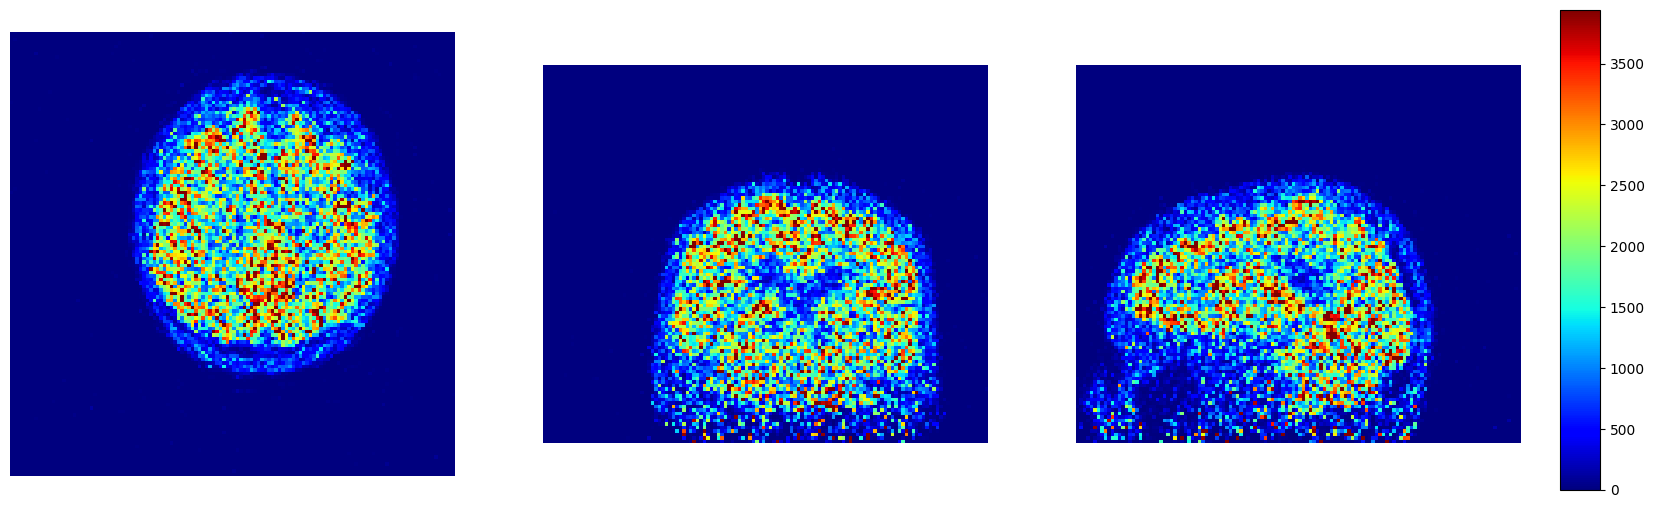

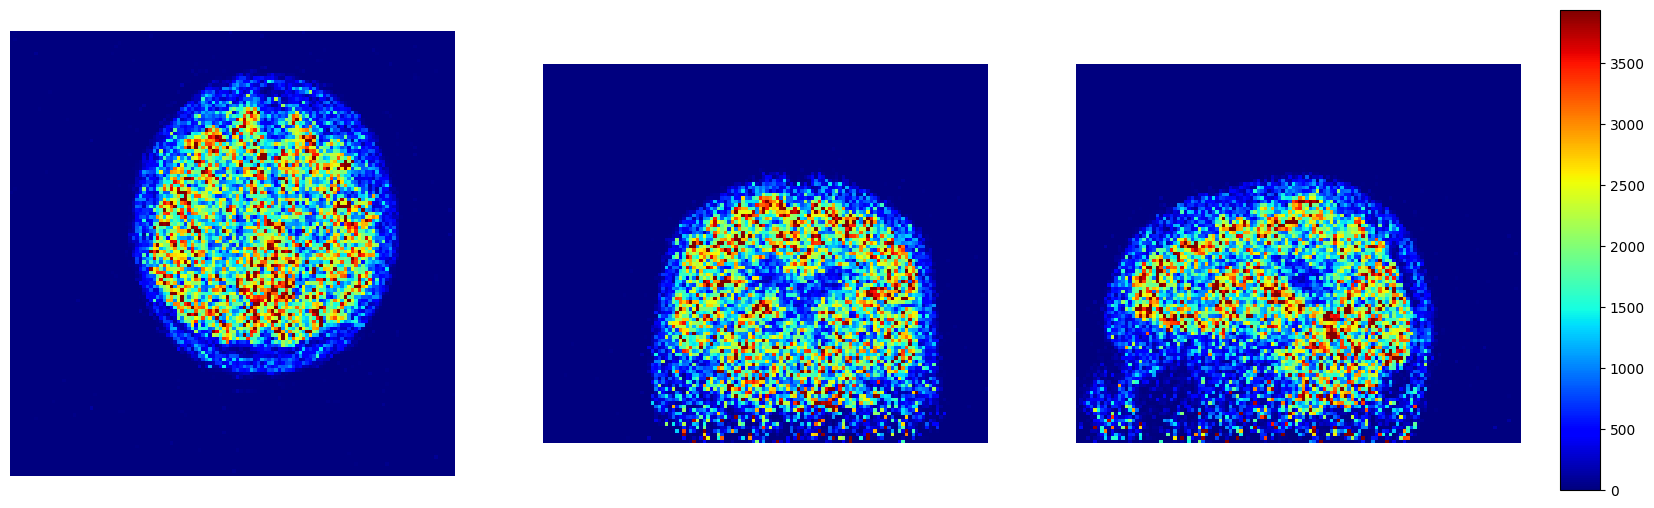

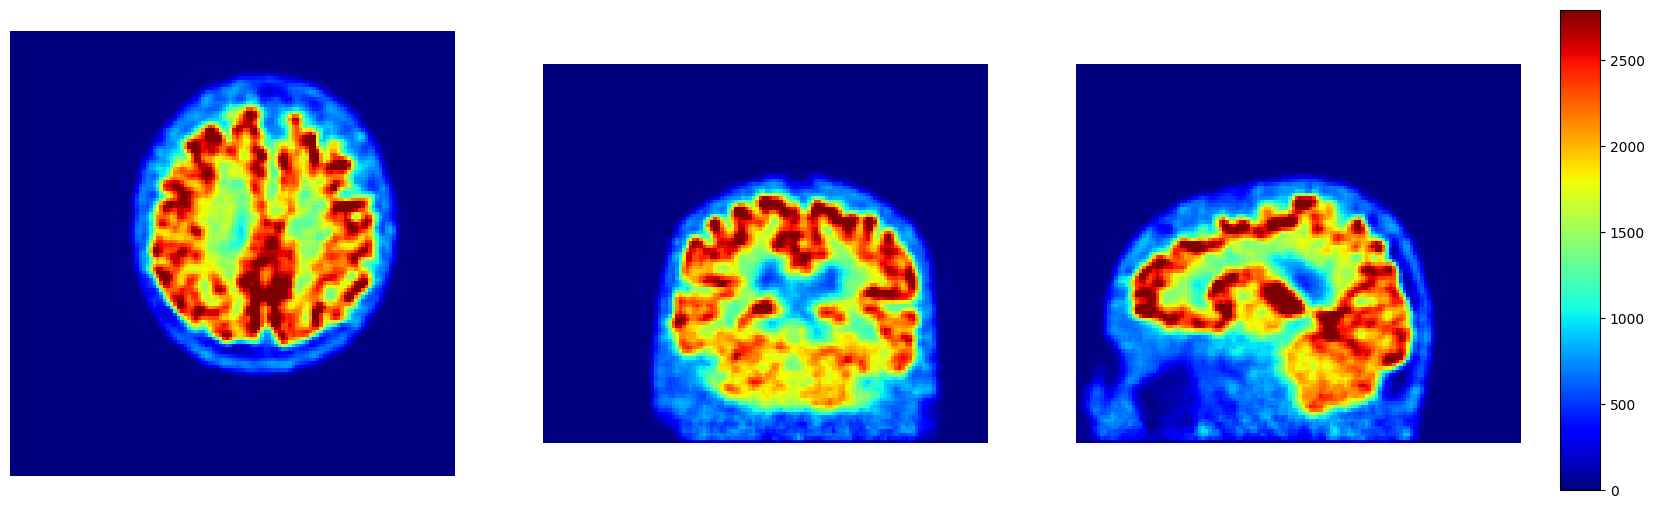

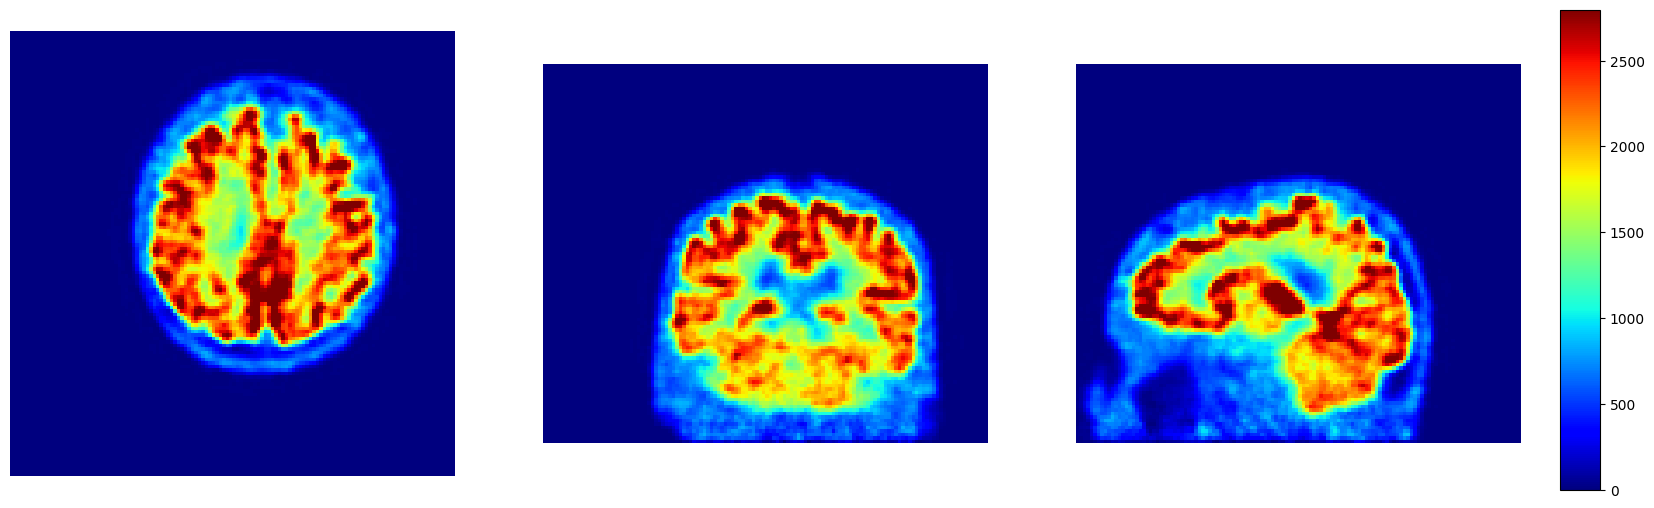

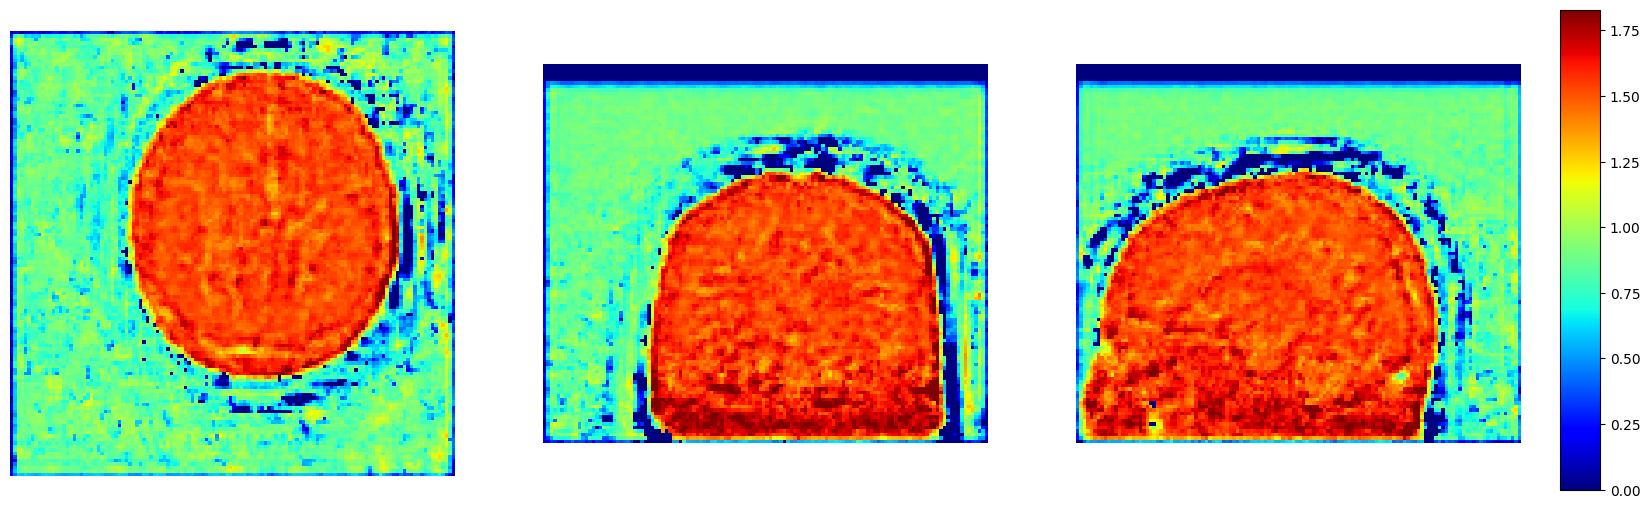

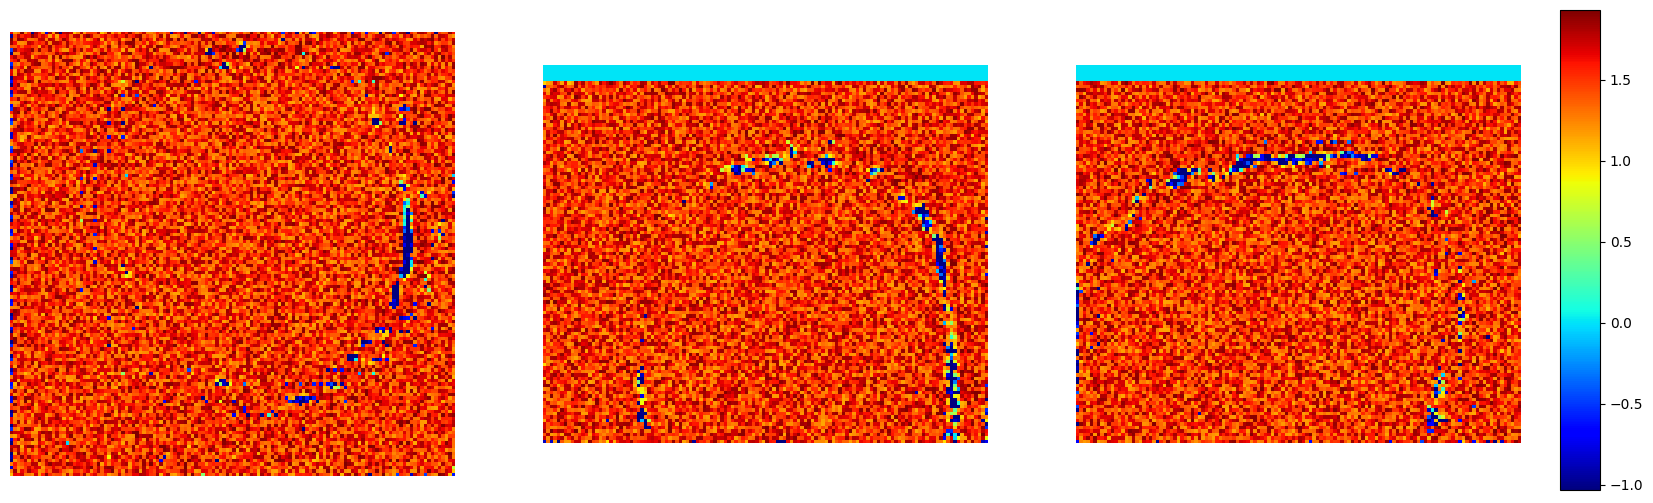

In [ ]:
x_noisy = preprocess_data(xnoisy).detach().requires_grad_()

x_per, loss = func_unknown(net2(x_noisy), x_noisy, net2, 1000, 2000, 0.002)
print(loss)
fig=PETLibs.utils.display3D_1cbar(postprocess_data(x_per),interpolation='none', perc=0.7)
fig=PETLibs.utils.display3D_1cbar(postprocess_data(x_noisy),interpolation='none', perc=0.7)
fig=PETLibs.utils.display3D_1cbar(postprocess_data(net2(x_noisy)),interpolation='none', perc=0.7)
fig=PETLibs.utils.display3D_1cbar(postprocess_data(net2(x_per)),interpolation='none', perc=0.7)
fig=PETLibs.utils.display3D_1cbar(postprocess_data(net2(x_per)-net2(x_noisy)),interpolation='none', perc=0.7)
fig=PETLibs.utils.display3D_1cbar(postprocess_data(x_per-x_noisy),interpolation='none', perc=0.7)

1.323133544921875


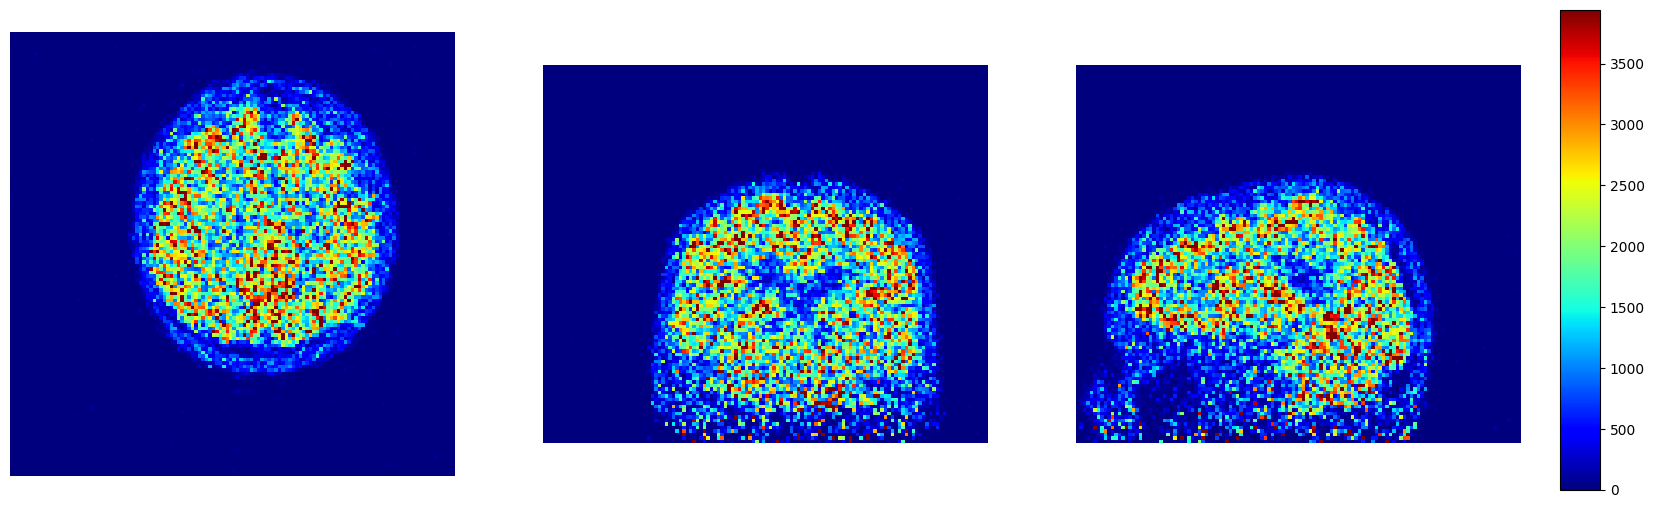

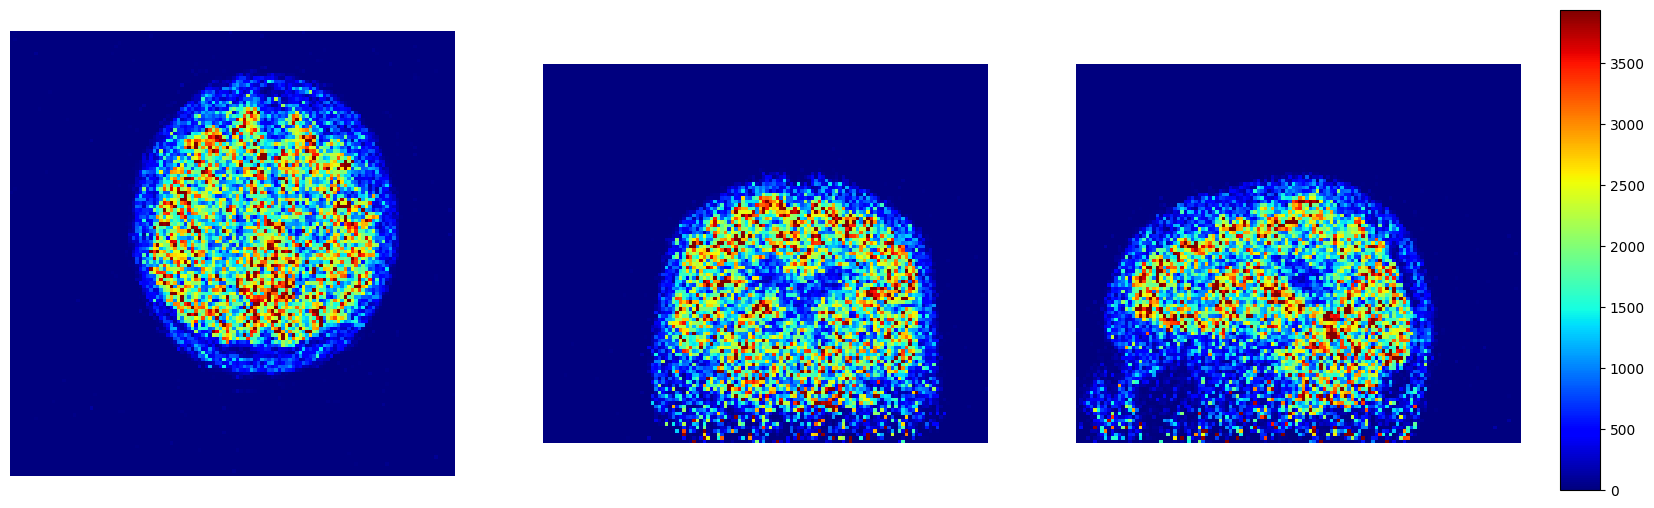

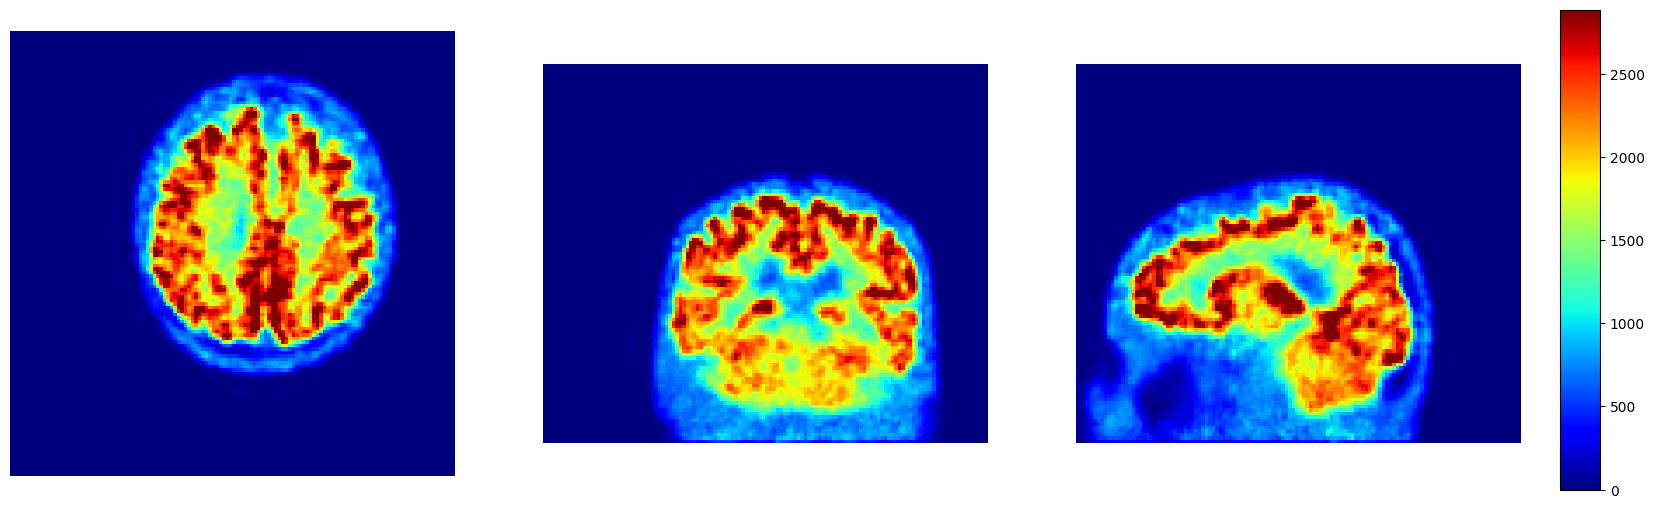

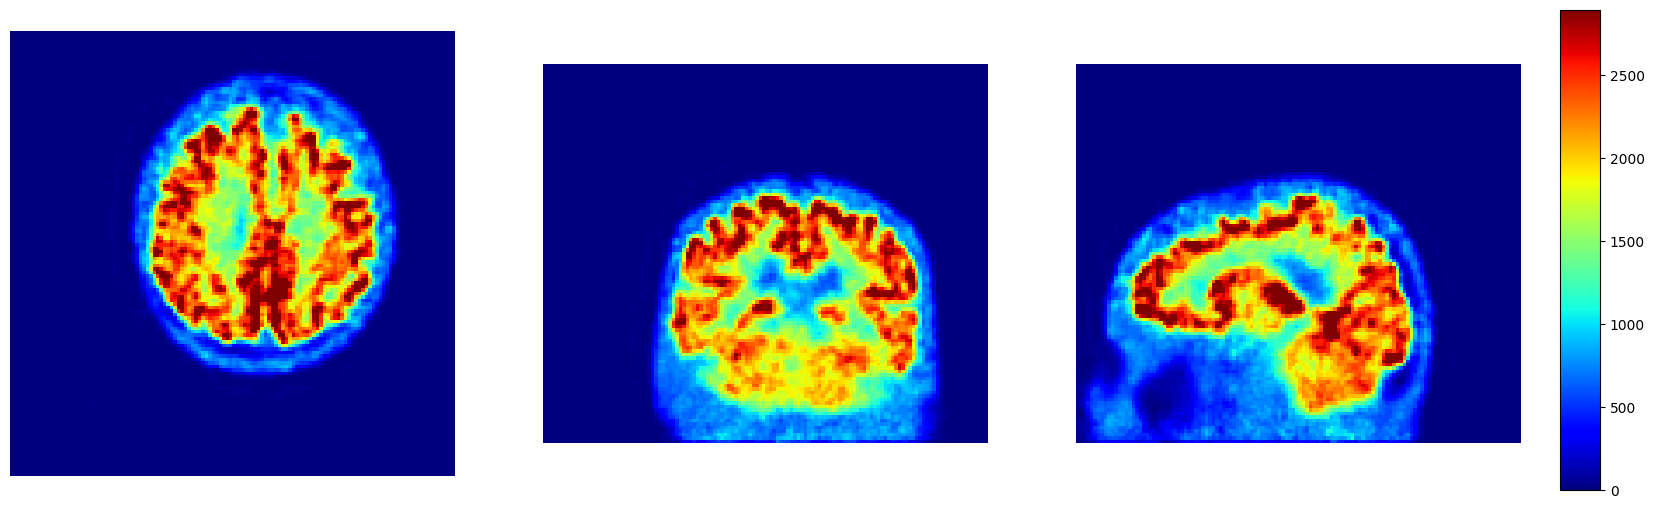

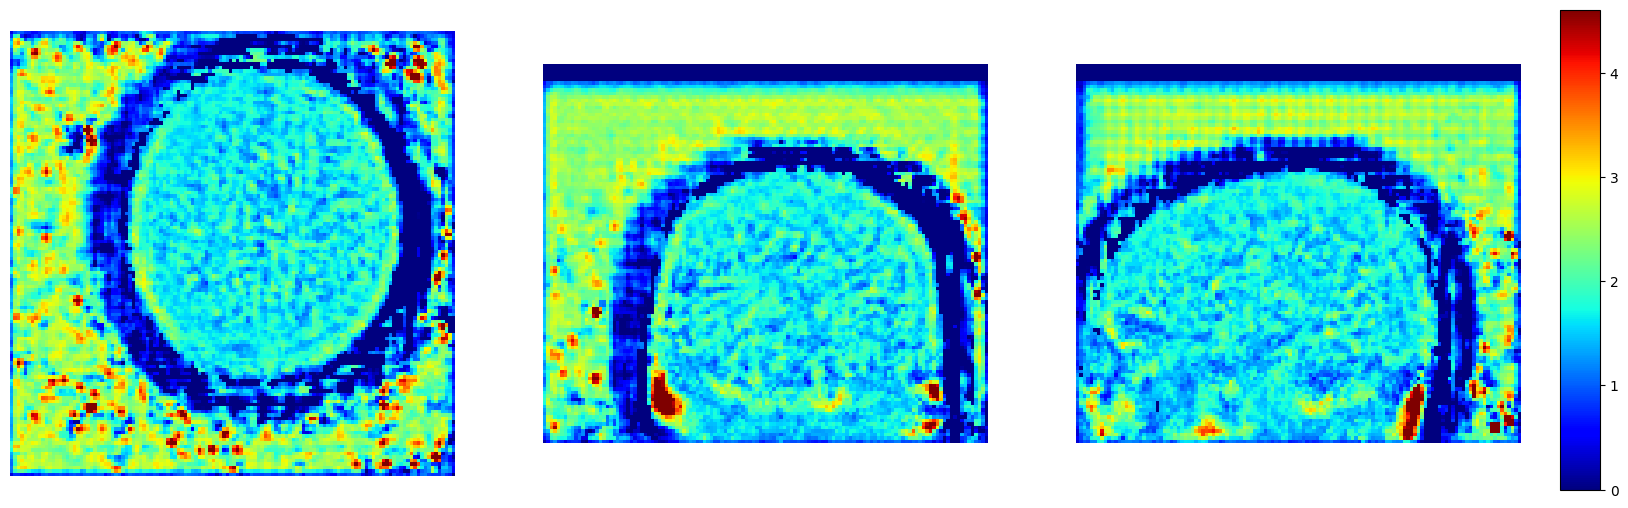

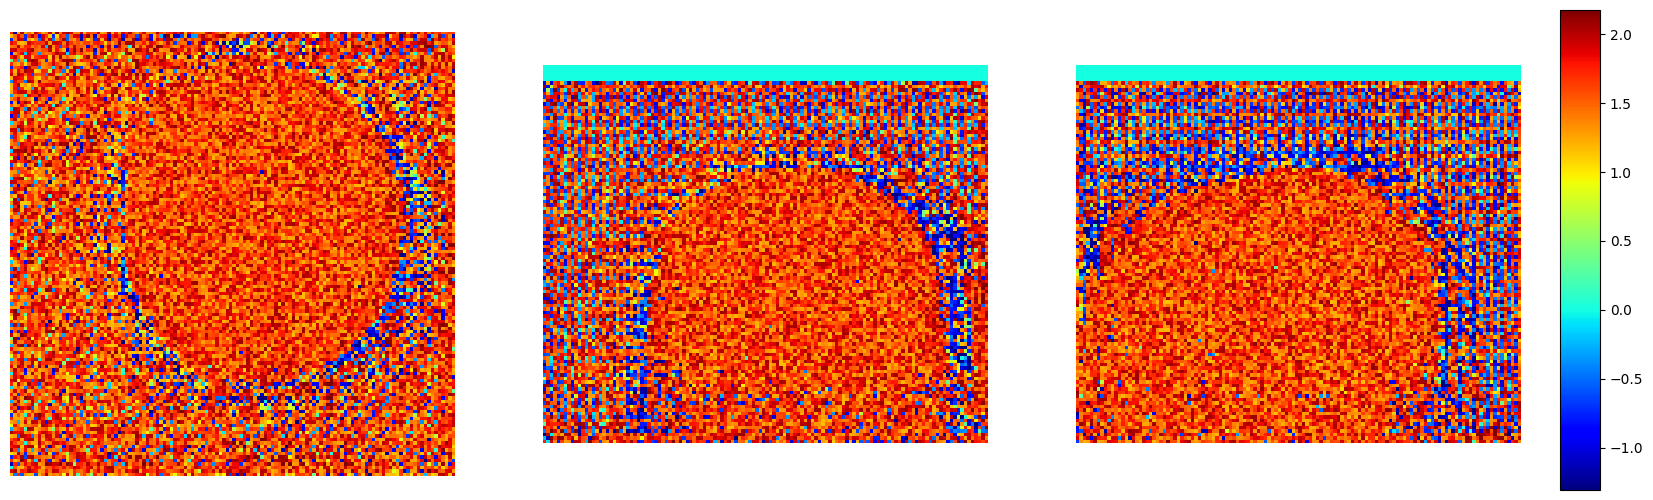

In [ ]:
x_noisy = preprocess_data(xnoisy).detach().requires_grad_()

x_per, loss = func_unknown(net1(x_noisy), x_noisy , net1 , 1000, 2000, 0.002)
print(loss)

fig=PETLibs.utils.display3D_1cbar(postprocess_data(x_per),interpolation='none', perc=0.7)
fig=PETLibs.utils.display3D_1cbar(postprocess_data(x_noisy),interpolation='none', perc=0.7)
fig=PETLibs.utils.display3D_1cbar(postprocess_data(net1(x_noisy)),interpolation='none', perc=0.7)
fig=PETLibs.utils.display3D_1cbar(postprocess_data(net1(x_per)),interpolation='none', perc=0.7)
fig=PETLibs.utils.display3D_1cbar(postprocess_data(net1(x_per)-net1(x_noisy)),interpolation='none', perc=0.7)
fig=PETLibs.utils.display3D_1cbar(postprocess_data(x_per-x_noisy),interpolation='none', perc=0.7)


### Making an arbitrary denoiser a FNE denoiser

> III. 5 When the lipschitz constant associated with $2D_\theta - I$ is equal to $L>1$ thus not satisfying property (FNE), one can derive another denoiser ${D}'_\theta$ as: ${D'}_\theta = (1-\frac{1}{2L}) I + \frac{1}{2L} (2D_\theta - I)$, such that it satisfies the property. Re-run PnP ADMM with such a denoiser and comment on the results.

In [ ]:
Lip = 1.0 #replace by jac_norm_net2 or jac_norm_net3
net = torch.nn.Identity() #replace by net2 or net3
FNE_net = lambda x: (1.0-0.5/Lip)*x+0.5/Lip*net(x)

In [ ]:
results_admm_FNE = pnp_admm(x0=xnoisy, nit_admm=30, model=FNE_net, pnlt_beta=pnlt_beta, max_iter_jacobian=2, BiographParams=ParamsGPUEM, dict_sino=dict_sino, target=preprocess_data(ordose),nb_everyIter_jac=nb_everyIter_jac )

Iterations ProxRecons: 100%|██████████| 140/140 [00:07<00:00, 17.53Iteration(s)/s]


Power Method:   0%|          | 0/2 [00:00<?, ?it/s]

jac= 1.0


Iterations ProxRecons: 100%|██████████| 140/140 [00:08<00:00, 17.33Iteration(s)/s]


Power Method:   0%|          | 0/2 [00:00<?, ?it/s]

jac= 1.0


Iterations ProxRecons: 100%|██████████| 140/140 [00:08<00:00, 16.22Iteration(s)/s]


Power Method:   0%|          | 0/2 [00:00<?, ?it/s]

jac= 1.0


Iterations ProxRecons: 100%|██████████| 140/140 [00:08<00:00, 16.35Iteration(s)/s]


Power Method:   0%|          | 0/2 [00:00<?, ?it/s]

jac= 1.0


Iterations ProxRecons: 100%|██████████| 140/140 [00:08<00:00, 17.40Iteration(s)/s]


Power Method:   0%|          | 0/2 [00:00<?, ?it/s]

jac= 1.0


Iterations ProxRecons: 100%|██████████| 140/140 [00:08<00:00, 17.40Iteration(s)/s]


Power Method:   0%|          | 0/2 [00:00<?, ?it/s]

jac= 1.0


Iterations ProxRecons: 100%|██████████| 140/140 [00:07<00:00, 17.68Iteration(s)/s]


Power Method:   0%|          | 0/2 [00:00<?, ?it/s]

jac= 1.0


Iterations ProxRecons: 100%|██████████| 140/140 [00:08<00:00, 17.47Iteration(s)/s]


Power Method:   0%|          | 0/2 [00:00<?, ?it/s]

jac= 1.0


Iterations ProxRecons: 100%|██████████| 140/140 [00:08<00:00, 17.45Iteration(s)/s]


Power Method:   0%|          | 0/2 [00:00<?, ?it/s]

jac= 1.0


Iterations ProxRecons: 100%|██████████| 140/140 [00:08<00:00, 17.49Iteration(s)/s]


Power Method:   0%|          | 0/2 [00:00<?, ?it/s]

jac= 1.0


Iterations ProxRecons: 100%|██████████| 140/140 [00:08<00:00, 17.47Iteration(s)/s]


Power Method:   0%|          | 0/2 [00:00<?, ?it/s]

jac= 1.0


Iterations ProxRecons: 100%|██████████| 140/140 [00:08<00:00, 17.25Iteration(s)/s]


Power Method:   0%|          | 0/2 [00:00<?, ?it/s]

jac= 1.0


Iterations ProxRecons: 100%|██████████| 140/140 [00:08<00:00, 17.34Iteration(s)/s]


Power Method:   0%|          | 0/2 [00:00<?, ?it/s]

jac= 1.0


Iterations ProxRecons: 100%|██████████| 140/140 [00:08<00:00, 17.40Iteration(s)/s]


Power Method:   0%|          | 0/2 [00:00<?, ?it/s]

jac= 1.0


Iterations ProxRecons: 100%|██████████| 140/140 [00:08<00:00, 17.28Iteration(s)/s]


Power Method:   0%|          | 0/2 [00:00<?, ?it/s]

jac= 1.0


Iterations ProxRecons: 100%|██████████| 140/140 [00:08<00:00, 17.26Iteration(s)/s]


Power Method:   0%|          | 0/2 [00:00<?, ?it/s]

jac= 1.0


Iterations ProxRecons: 100%|██████████| 140/140 [00:08<00:00, 17.39Iteration(s)/s]


Power Method:   0%|          | 0/2 [00:00<?, ?it/s]

jac= 1.0


Iterations ProxRecons: 100%|██████████| 140/140 [00:08<00:00, 17.36Iteration(s)/s]


Power Method:   0%|          | 0/2 [00:00<?, ?it/s]

jac= 1.0


Iterations ProxRecons: 100%|██████████| 140/140 [00:08<00:00, 17.44Iteration(s)/s]


Power Method:   0%|          | 0/2 [00:00<?, ?it/s]

jac= 1.0


Iterations ProxRecons: 100%|██████████| 140/140 [00:08<00:00, 17.37Iteration(s)/s]


Power Method:   0%|          | 0/2 [00:00<?, ?it/s]

jac= 1.0


Iterations ProxRecons: 100%|██████████| 140/140 [00:08<00:00, 17.43Iteration(s)/s]


Power Method:   0%|          | 0/2 [00:00<?, ?it/s]

jac= 1.0


Iterations ProxRecons: 100%|██████████| 140/140 [00:08<00:00, 17.27Iteration(s)/s]


Power Method:   0%|          | 0/2 [00:00<?, ?it/s]

jac= 1.0


Iterations ProxRecons: 100%|██████████| 140/140 [00:08<00:00, 17.40Iteration(s)/s]


Power Method:   0%|          | 0/2 [00:00<?, ?it/s]

jac= 1.0


Iterations ProxRecons: 100%|██████████| 140/140 [00:08<00:00, 17.48Iteration(s)/s]


Power Method:   0%|          | 0/2 [00:00<?, ?it/s]

jac= 1.0


Iterations ProxRecons: 100%|██████████| 140/140 [00:07<00:00, 17.59Iteration(s)/s]


Power Method:   0%|          | 0/2 [00:00<?, ?it/s]

jac= 1.0


Iterations ProxRecons: 100%|██████████| 140/140 [00:08<00:00, 17.21Iteration(s)/s]


Power Method:   0%|          | 0/2 [00:00<?, ?it/s]

jac= 1.0


Iterations ProxRecons: 100%|██████████| 140/140 [00:08<00:00, 17.48Iteration(s)/s]


Power Method:   0%|          | 0/2 [00:00<?, ?it/s]

jac= 1.0


Iterations ProxRecons: 100%|██████████| 140/140 [00:08<00:00, 17.43Iteration(s)/s]


Power Method:   0%|          | 0/2 [00:00<?, ?it/s]

jac= 1.0


Iterations ProxRecons: 100%|██████████| 140/140 [00:08<00:00, 17.36Iteration(s)/s]


Power Method:   0%|          | 0/2 [00:00<?, ?it/s]

jac= 1.0


Iterations ProxRecons: 100%|██████████| 140/140 [00:08<00:00, 17.28Iteration(s)/s]


Power Method:   0%|          | 0/2 [00:00<?, ?it/s]

jac= 1.0


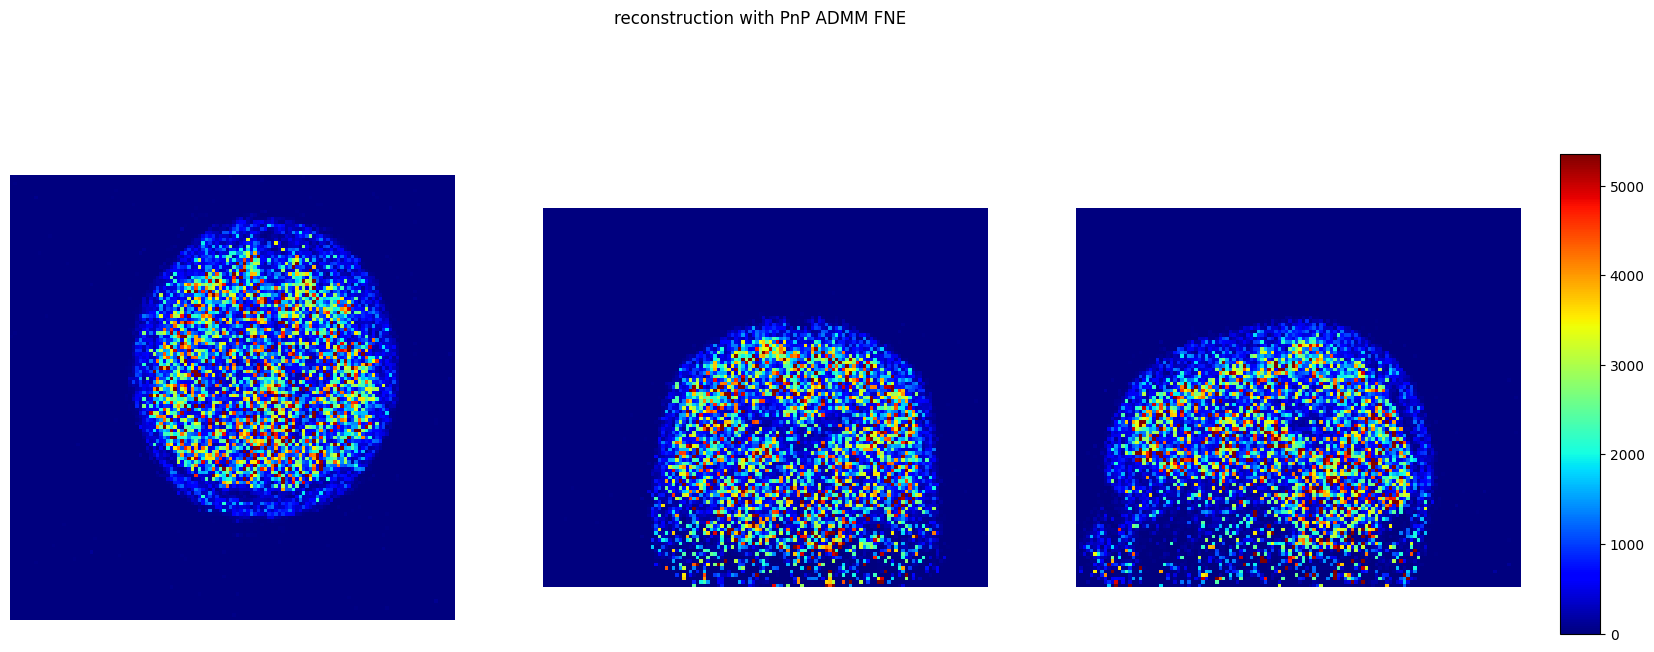

In [ ]:
x_admm_FNE = results_admm_FNE["x"].squeeze().cpu().detach().numpy()
mse_admm_FNE = results_admm_FNE["mse"]
# reg_admm_jac = results_admm_FNE["reg"]
logl_admm_FNE = results_admm_FNE["logl"]
norm1_admm_FNE = results_admm_FNE["norm1"]
norm2_admm_FNE = results_admm_FNE["norm2"]

fig=PETLibs.utils.display3D_1cbar(x_admm_FNE,interpolation='none', perc=0.7, title='reconstruction with PnP ADMM FNE')

## Part IV: PnP FB with gradient surrogate

GS-net1 is a denoiser that writes as $N(x) + J_{N(x)}^\top (x - N(x))$.

The forward backward algorithm for PET reconstruction (minimize $LL(x) + r(x)$) with $r$ non convex function with lipschitz differentiable gradient writes as
$$
{x^{k+1}} {= prox_{\tau LL+ \iota_{\left[0,+\infty\right[^N}}(x^k -  \tau \nabla r(x^k))}\\
%x^{k+1}_\lambda = prox_{\tau LL+ \iota_{\left[0,+\infty\right[^N}}(\lambda \tau {D_{\theta}}(x^k_\lambda) + (1-\lambda \tau) x^k_\lambda)$$
where the step size $\tau$ is set using a backtracking linesearch.

> IV.1 What is the advantage and disadvantages of such lineseach?

> IV.2 Explore the forward backward algorithm when $r = \|\nabla x\|^2_2$ as implemented below. What could be a PnP version of the FB algorithm where GS-net1 acts as a regularization ?

In [ ]:

def forword_backward(x0, nit_fb, reg_par, BiographParams, dict_sino):

    x=torch.tensor(np.zeros_like(x0), dtype=torch.float32,device="cuda")

    # define the finite differences operator

    Dh = torch.tensor([[[0., 0., 0.],
                        [0., 0., 0.],
                        [0., 0., 0.]],
                        [[0., 0., 0.],
                        [-1, 1., 0.],
                        [0., 0., 0.]],
                        [[0., 0., 0.],
                        [0., 0., 0.],
                        [0., 0., 0.]]]).view(1,1,3,3,3).cuda()


    Dp = torch.tensor([[[0., 0., 0.],
                    [0., -1., 0.],
                    [0., 0., 0.]],
                    [[0., 0., 0.],
                    [0., 1., 0.],
                    [0., 0., 0.]],
                    [[0., 0., 0.],
                    [0., 0., 0.],
                    [0., 0., 0.]]]).view(1,1,3,3,3).cuda()

    Dv = torch.tensor([[[0., 0., 0.],
                    [0., 0., 0.],
                    [0., 0., 0.]],
                    [[0., -1., 0.],
                    [0., 1., 0.],
                    [0., 0., 0.]],
                    [[0., 0., 0.],
                    [0., 0., 0.],
                    [0., 0., 0.]]]).view(1,1,3,3,3).cuda()


    D = torch.concatenate([Dh, Dp, Dv], dim=0)

    # and its adjoint

    Dh_star = torch.tensor([[[0., 0., 0.],
                        [0., 0., 0.],
                        [0., 0., 0.]],
                        [[0., 0., 0.],
                        [0., 1., -1.],
                        [0., 0., 0.]],
                        [[0., 0., 0.],
                        [0., 0., 0.],
                        [0., 0., 0.]]]).view(1,1,3,3,3).cuda()


    Dp_star = torch.tensor([[[0., 0., 0.],
                    [0., 0., 0.],
                    [0., 0., 0.]],
                    [[0., 0., 0.],
                    [0., 1., 0.],
                    [0., 0., 0.]],
                    [[0., 0., 0.],
                    [0., -1., 0.],
                    [0., 0., 0.]]]).view(1,1,3,3,3).cuda()

    Dv_star = torch.tensor([[[0., 0., 0.],
                    [0., 0., 0.],
                    [0., 0., 0.]],
                    [[0., 0., 0.],
                    [0., 1., 0.],
                    [0., -1., 0.]],
                    [[0., 0., 0.],
                    [0., 0., 0.],
                    [0., 0., 0.]]]).view(1,1,3,3,3).cuda()


    D_star = torch.concatenate([Dh_star, Dp_star, Dv_star], dim=1)

    tau = 0.1/(reg_par)

    # parameters for backtracking linesearch
    epsilon = 1e-9
    delta = epsilon + 1e-6
    gamma = 1e-5
    eta = 0.9
    i=0
    xprec = x


    while i <nit_fb and delta > epsilon:

        xprec = x
        backtracking_check = True
        sub_counter = 0


        while backtracking_check:

            u = x - (tau*reg_par*postprocess_data(F.conv3d(F.conv3d(preprocess_data(x, tensorFlag=True), D, padding=1), D_star, padding=1), tensorFlag=True))
            xprox = u
            x=GPUBiographProxRecons(BiographReconsParams=BiographParams,xprox=xprox,pnlt_beta=1.0/tau,dict_sino=dict_sino, tensor_output = True).squeeze()

            lk = GPU_log_likelihood(x, eps =0, BiographParams=BiographParams,dict_sino=dict_sino)

            gx = reg_par*0.5*torch.norm(F.conv3d(preprocess_data(x, tensorFlag=True), D, padding=1))**2

            if sub_counter > 0:
                lossprec = loss
            if i== 0 and sub_counter == 0:
                linit = lk

            loss = -lk + lbd*gx

            ## Backtracking linesearch: If loss function is not increasing, we decrease tau
            if (sub_counter == 0 or torch.abs(lossprec -loss) < (gamma/tau)*torch.norm(xprec-x)**2) :
                # continue backtracking
                tau = eta*tau
                x = xprec
                backtracking_check = True
            else:
                # move on to next iteration
                if sub_counter > 0 and i > 0:
                    delta  = torch.abs((lossprec-loss)/linit)
                backtracking_check = False


            sub_counter += 1
        i += 1



    return x

Iterations ProxRecons: 100%|██████████| 140/140 [00:07<00:00, 17.58Iteration(s)/s]


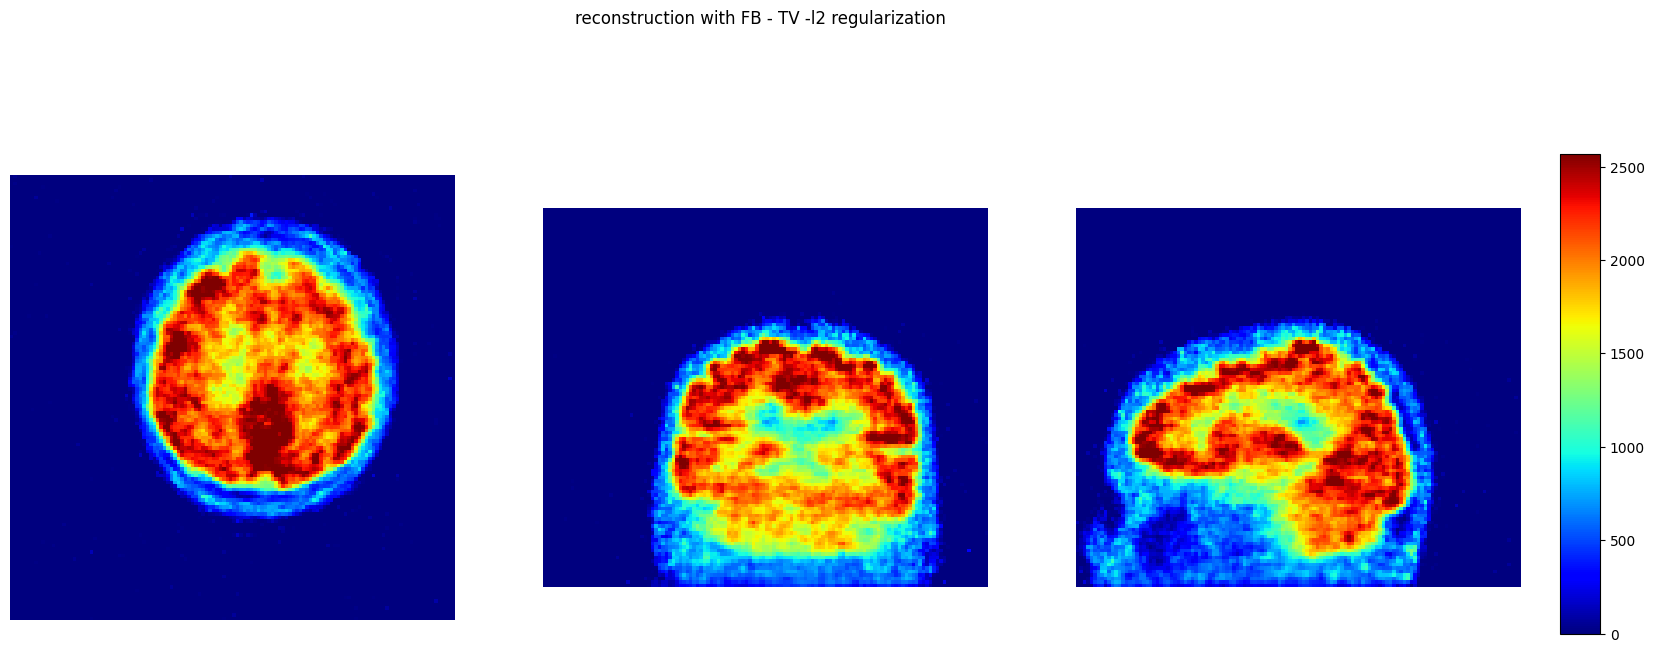

In [ ]:
nit_fb = 20
lbd = 0.0000002


x_admm = forward_backward(x0=ordose, nit_fb=nit_fb, reg_par=lbd, BiographParams=ParamsGPUEM, dict_sino=dict_sino)
x_admm = x_admm.squeeze().cpu().detach().numpy()

fig=PETLibs.utils.display3D_1cbar(x_admm,interpolation='none', perc=0.7, title='reconstruction with FB - TV -l2 regularization')

Construct and load GSDenoiser

In [ ]:

from TP_janv25.DL_utils import MyDeepModel2


class MyGSDenoiser(torch.nn.Module):
    def __init__(self):
        super(MyGSDenoiser, self).__init__()
        self.base = MyDeepModel2()

    def forward(self, x):
        x = x.float()
        x = x.requires_grad_()
        N = self.base.forward(x)
        JN = torch.autograd.grad(N, x, grad_outputs=x - N, create_graph=True, only_inputs=True)[0]
        Dg = x - N - JN
        x_hat = x - Dg

        x_hat = x_hat.detach()
        x = x.detach()
        N = N.detach()
        JN = JN.detach()


        return x_hat

    def getN(self, x):
        x = x.float()
        # x = x.requires_grad_()
        N = self.base.forward(x)
        return N



GSnet = MyGSDenoiser()
GSnet = GSnet.cuda()


filename = data_TP_folder+'gsnet.ckpt'
checkpoint = torch.load(filename)
GSnet.load_state_dict(checkpoint['state_dict'], strict=True)
GSnet.eval()


<ipython-input-49-b5ae9b34c734>:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


MyGSDenoiser(
  (base): MyDeepModel2(
    (model): NFDRUNet(
      (down_path): ModuleList(
        (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): NFDownBlock(
          (branch): Sequential(
            (0): NFResBlock(
              (residual_preact): Sequential(
                (0): Scaling(1.4142135623730951)
              )
              (residual_branch): Sequential(
                (0): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
                (1): ELU(alpha=1.0)
              )
            )
          )
          (downsample): Conv3d(32, 64, kernel_size=(2, 2, 2), stride=(2, 2, 2), bias=False)
        )
        (2): NFDownBlock(
          (branch): Sequential(
            (0): NFResBlock(
              (residual_preact): Sequential(
                (0): Scaling(1.4142135623730951)
              )
              (residual_branch): Sequential(
                (0): Conv3d(64, 64, k

> Write the PnP version of the forward backward algorithm with GSnet

In [ ]:
def pnp_forward_backward(x0, nit_fb, reg_par, BiographParams, dict_sino, net):

    x=torch.tensor(np.zeros_like(x0), dtype=torch.float32,device="cuda")



    tau = 1.99/(reg_par)
    epsilon = 1e-9
    delta = epsilon + 1e-6
    gamma = 1e-5
    eta = 0.9
    i=0
    xprec = x


    while i <nit_fb and delta > epsilon:
        print("#########################################################")
        print(f"i={i} over {nit_fb}")
        print("#########################################################")

        xprec = x
        backtracking_check = False
        sub_counter = 0


        while not backtracking_check:
            # print("#########################################################")
            # print(x.shape)
            # print(preprocess_data(x, tensorFlag=True).shape)
            # print(net(preprocess_data(x, tensorFlag=True)).shape)
            u =  postprocess_data((tau*reg_par*net(preprocess_data(x, tensorFlag=True))),tensorFlag=True) + (1-reg_par*tau)*x
            # print(u.shape)


            xprox=u
            x=GPUBiographProxRecons(BiographReconsParams=BiographParams,xprox=xprox,pnlt_beta=1.0/tau,dict_sino=dict_sino, tensor_output = True).squeeze()
            # print(x.shape)

            lk = GPU_log_likelihood(x, eps =0, BiographParams=BiographParams,dict_sino=dict_sino)
            # x=torch.swapaxes(x,2,0).cpu()


            ## compute regularization
            Nx = postprocess_data(net.getN(preprocess_data(x,tensorFlag=True)),tensorFlag=True)
            gx = 0.5*torch.sum((x - Nx).flatten() ** 2).item()

            if sub_counter > 0:
                lossprec = loss
            if i== 0 and sub_counter == 0:
                linit = lk

            loss = -lk + gx


            ## Update parameters
            if (sub_counter > 0 and np.abs(lossprec -lk) < (gamma/tau)*torch.norm(xprec-x)**2) :
                tau = eta*tau
                x = xprec
                backtracking_check = False
            else:
                if sub_counter > 0 and i > 0:
                    delta  = np.abs((lossprec-lk)/linit)
                backtracking_check = True


            sub_counter += 1
            i += 1

    return x

Test PnP reconstruction with GSnet

In [ ]:
nit_fb = 20
lbd = 0.00002

x_admm = pnp_forward_backward(x0=ordose, nit_fb=nit_fb, reg_par=lbd, BiographParams=ParamsGPUEM, dict_sino=dict_sino, net=GSnet)
x_admm = x_admm.squeeze().cpu().detach().numpy()



#########################################################
i=0 over 20
#########################################################


Iterations ProxRecons: 100%|██████████| 140/140 [00:08<00:00, 17.31Iteration(s)/s]


#########################################################
i=1 over 20
#########################################################


Iterations ProxRecons: 100%|██████████| 140/140 [00:07<00:00, 17.55Iteration(s)/s]


#########################################################
i=2 over 20
#########################################################


Iterations ProxRecons: 100%|██████████| 140/140 [00:08<00:00, 16.89Iteration(s)/s]


#########################################################
i=3 over 20
#########################################################


Iterations ProxRecons: 100%|██████████| 140/140 [00:08<00:00, 17.17Iteration(s)/s]


#########################################################
i=4 over 20
#########################################################


Iterations ProxRecons: 100%|██████████| 140/140 [00:08<00:00, 17.38Iteration(s)/s]


#########################################################
i=5 over 20
#########################################################


Iterations ProxRecons: 100%|██████████| 140/140 [00:07<00:00, 17.53Iteration(s)/s]


#########################################################
i=6 over 20
#########################################################


Iterations ProxRecons: 100%|██████████| 140/140 [00:07<00:00, 17.69Iteration(s)/s]


#########################################################
i=7 over 20
#########################################################


Iterations ProxRecons: 100%|██████████| 140/140 [00:07<00:00, 17.63Iteration(s)/s]


#########################################################
i=8 over 20
#########################################################


Iterations ProxRecons: 100%|██████████| 140/140 [00:07<00:00, 17.65Iteration(s)/s]


#########################################################
i=9 over 20
#########################################################


Iterations ProxRecons: 100%|██████████| 140/140 [00:07<00:00, 17.56Iteration(s)/s]


#########################################################
i=10 over 20
#########################################################


Iterations ProxRecons: 100%|██████████| 140/140 [00:08<00:00, 17.48Iteration(s)/s]


#########################################################
i=11 over 20
#########################################################


Iterations ProxRecons: 100%|██████████| 140/140 [00:08<00:00, 17.42Iteration(s)/s]


#########################################################
i=12 over 20
#########################################################


Iterations ProxRecons: 100%|██████████| 140/140 [00:08<00:00, 17.39Iteration(s)/s]


#########################################################
i=13 over 20
#########################################################


Iterations ProxRecons: 100%|██████████| 140/140 [00:08<00:00, 17.50Iteration(s)/s]


#########################################################
i=14 over 20
#########################################################


Iterations ProxRecons: 100%|██████████| 140/140 [00:08<00:00, 17.41Iteration(s)/s]


#########################################################
i=15 over 20
#########################################################


Iterations ProxRecons: 100%|██████████| 140/140 [00:08<00:00, 17.48Iteration(s)/s]


#########################################################
i=16 over 20
#########################################################


Iterations ProxRecons: 100%|██████████| 140/140 [00:08<00:00, 17.38Iteration(s)/s]


#########################################################
i=17 over 20
#########################################################


Iterations ProxRecons: 100%|██████████| 140/140 [00:07<00:00, 17.56Iteration(s)/s]


#########################################################
i=18 over 20
#########################################################


Iterations ProxRecons: 100%|██████████| 140/140 [00:08<00:00, 17.48Iteration(s)/s]


#########################################################
i=19 over 20
#########################################################


Iterations ProxRecons: 100%|██████████| 140/140 [00:08<00:00, 17.38Iteration(s)/s]


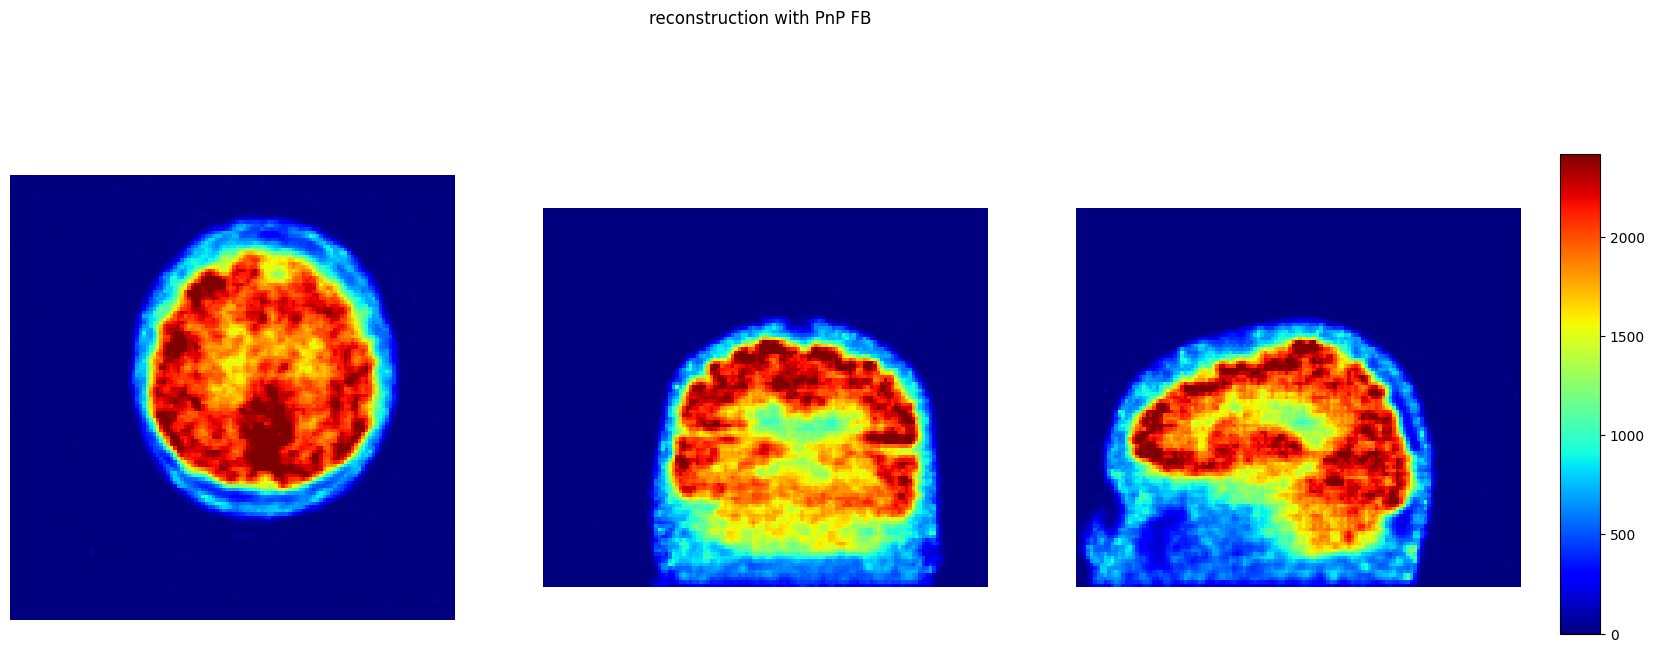

In [ ]:
fig=PETLibs.utils.display3D_1cbar(x_admm,interpolation='none', perc=0.7, title='reconstruction with PnP FB')